In [1]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib import pyplot as plt

matplotlib.style.use('classic')
plt.rcParams["figure.figsize"] = (14,10)

from gurobipy import Model, GRB

from tqdm import tqdm

# Lösung zur Sonderübung 4

## Aufgabe 4.1

### b)
Schreiben Sie eine Funktion parkettierung $(X^0,r)$, die als
Eingabe eine Box $X^0\subseteq\mathbb{R}^2$, sowie die Anzahl $r\in\mathbb{N}$ an Unterteilungsschritten erhält und eine Liste von gleichmäßig unterteilten Teilboxen $X^1,\ldots,X^k, k = 4r$ zurückgibt
(vgl. Abb. 3.18, GO-Buch).

In [2]:
def parkettierung(X,r):
    res = np.array([X])
    for j in range(r):
        temp = np.zeros((4**(j+1), 2, 2))
        for i, box in enumerate(res):
            c = (box[0]+box[1])/2
            temp[4*i,:,:] = [box[0], c]
            temp[4*i+1,:,:] = [c, box[1]]
            temp[4*i+2,:,:] = [[c[0],box[0,1]],[box[1,0], c[1]]]
            temp[4*i+3,:,:] = [[box[0,0], c[1]],[c[0], box[1,1]]]
            res = temp
    return res

### c)
Schreiben Sie eine Funktion get_lower_bound $(X^0,r)$, die
für einen Punkt $z\in\mathbb{R}$, eine Box $X^0\subseteq\mathbb{R}^2$ und eine Anzahl $r\in\mathbb{N}$ an gleichmäßigen
Unterteilungsschritten eine möglichst genaue Unterschranke $\hat{v}$ an den Minimalwert $v$
des Distanzproblems $P$ aus Aufgabe S3.1, sowie einen zugehörigen Punkt $\hat{x}\in\bigcup_{l=1}^k \hat{M}^l$ bestimmt.
Bestimmen Sie hierzu mit Hilfe von Aufgabenteil b) zunächst alle Teilboxen $X^1,\ldots,X^k$ und lösen Sie für jedes $l=1,\ldots,k$ das konvexe Optimierungsproblem
\begin{equation*}
    \hat{P^l}\colon\qquad \min_{x\in\mathbb{R}^2}\Vert x-z\Vert_2^2\qquad\text{s.t.}\qquad\hat{g}_l(x)\leq 0,x\in X^l.
\end{equation*}
Hinweis: Zum Lösen des Optimierungsproblems können Sie Gurobi
oder einen Standardsolver aus dem Scipy-
Paket verwenden.

In [3]:
def get_lower_bound(X,r):
    err = 0
    p = parkettierung(X,r)
    v_hut = np.inf
    pbar = tqdm(p, desc = "Solving")
    for box in pbar:
        m = Model()
        m.setParam('OutputFlag', False)
        x = m.addMVar(shape=2,vtype = GRB.CONTINUOUS, lb=box[0], ub=box[1])
        m.setObjective((x[0]-2)**2+(x[1]-2)**2)
        m.addConstr(4-(x[0]-2)**2-4*(x[1]-2)**2+4*((box[0,0]-x[0])*(box[1,0]-x[0])+(box[0,1]-x[1])*(box[1,1]-x[1])) <= 0)
        m.update()
        m.optimize()
        
        try:
            if m.ObjVal < v_hut:
                v_hut = m.ObjVal
                x_hut = m.x
                pbar.set_postfix_str(f"Best value: {v_hut}")
        except: 
            pass
    
    return v_hut, x_hut
    

### d)
Testen Sie Ihren Algorithmus für $X^0 = [-1,5] \times [0, 4]$ und $r = 3$. Geben Sie $\hat{x}$
und $\hat{v}$ aus. Wie lautet die gefundene Unterschranke an die Distanz von $z$ zu $M^0$?

In [5]:
X = np.array([[-1,5],[0,4]]).T
v_hut, x_hut = get_lower_bound(X,3)
print(f"V_hut: {v_hut}")
print(f"x_hut: {x_hut}")

Solving: 100%|██████████| 64/64 [00:00<00:00, 1719.36it/s, Best value: 0.8835106809279605]

V_hut: 0.8835106809279605
x_hut: [2.237893285286073, 1.0906500160460246]


### e)
Siehe Sonderübungsblatt.

100%|██████████| 64/64 [00:00<00:00, 1002.68it/s]


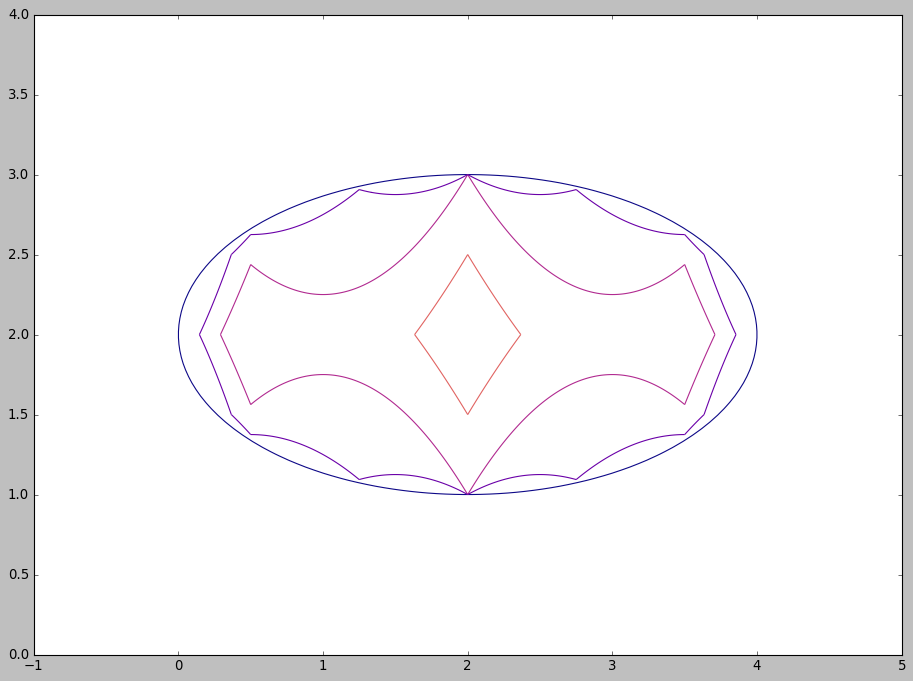

In [8]:
def g(X1, X2):
    return 4-(X1-2)**2-4*(X2-2)**2

def g_hat(X1, X2, box):
    return 4-(X1-2)**2-4*(X2-2)**2+4*((box[0,0]-X1)*(box[1,0]-X1)+(box[0,1]-X2)*(box[1,1]-X2))


X1 = np.linspace(-1, 5, 100)
X2 = np.linspace(0, 4, 100)
X1, X2 = np.meshgrid(X1, X2)

cmap = cm.get_cmap('plasma')

plt.contour(X1, X2, g(X1,X2), levels=0, colors=cmap(0))

def plot_parketting(p, color):
    for box in tqdm(p):
        X1 = np.linspace(box[0,0], box[1,0], 100)
        X2 = np.linspace(box[0,1], box[1,1], 100)
        X1, X2 = np.meshgrid(X1, X2)
        Z = g_hat(X1, X2, box=box)
        if np.any(Z>0) and np.any(Z<0):
            plt.contour(X1, X2, Z, levels=0, colors=color)


for i, color in zip(range(1,4),[cmap(0.6), cmap(0.4), cmap(0.2)]):
    plot_parketting(parkettierung(X,i), color=color)

## Aufgabe 4.2

### b)
Plotten Sie $f$ auf $X\times Y=[-2,2]\times[-2,2]$.

### c)
Implementieren Sie die Funktion $\hat{f_{\alpha}}$ und vergleichen Sie diese mit $\hat{f}$ auf $X\times Y=[-2,2]\times[-2,2]$, indem Sie die Funktionen zusammen in einem Plot darstellen.